# Implementation of RNN & LSTM

RNN have some kind of built-in "memory". Therefore, they are useful for tasks that are time or sequence dependent.

Challenges in designing and implementing any kind of RNN:

1. How to pre-process sequential data: Transform into numerical data for RNN
2. How can we represent memory in code?

## `Simple RNN` for Time-Series Prediction
- [Link](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/recurrent-neural-networks/time-series/Simple_RNN.ipynb)
- Simple RNN to do time-series prediction given some generated input data. 

Steps are: 

1. Create data
2. Define an RNN in Python
3. Train network and see how it performs

### Import resources and create data

In [1]:
# numpy
import numpy as np

# torch imports
import torch
from torch import nn

# Vis
import matplotlib.pyplot as plt
%matplotlib inline

three time_steps: [0.         0.15707963 0.31415927]
data.shape:  (21,)
data.shape:  (21, 1)


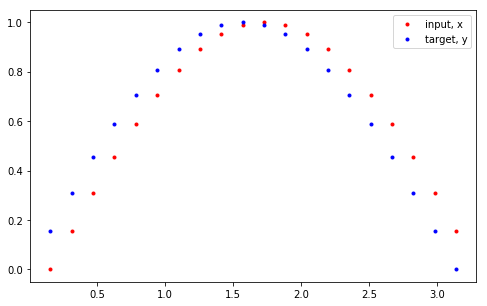

In [2]:
# vis
plt.figure(figsize=(8,5))

# time steps / data points in one batch of data
seq_length = 20

# generate data pts
time_steps = np.linspace(0, np.pi, seq_length+1)
print("three time_steps:",time_steps[:3])

data = np.sin(time_steps)
print("data.shape: ", data.shape)
data.resize((seq_length + 1, 1))
print("data.shape: ", data.shape)

x = data[:-1]
y = data[1:]

# show me the data
plt.plot(time_steps[1:], x, "r.", label="input, x")
plt.plot(time_steps[1:], y, "b.", label="target, y")

plt.legend(loc="best")
plt.show()

### Define the RNN

Define a class (OOP) to build an RNN in PyTorch. 

- `nn.RNN` to create an RNN layer
- Add fully-connected layer to get the output size we want

#### `nn.RNN`

- [Documentation nn.RNN](https://pytorch.org/docs/stable/nn.html#rnn)

This class applies a multi-layer Elman RNN to an input sequence (either using *tanh* or *ReLU*). Default: `tanh`, then for each element in the input sequence, each layer computes the following function: 

$$
h_t = tanh(W_{ih} \cdot x_t + b_{ih} + W_{hh} \cdot h_{(t-1)} + b_{hh})
$$

where 

- $h_t$ is the hidden state at time t,
- $x_t$ is the input at time t, 
- $h_{(t-1)}$ is the hidden state of the previous layer at time t-1 or the initial hidden state at time 0.

Parameters: 

- **input_size**: What is the size of the input?
- **hidden_size**: How many features does the hidden state h has?
- **num_layers**: How many layers should the RNN have? Typically 1-3, greater than 1 means that stacked RNN are created.
- **batch_first**: Should the input and output tensors be provided as `(batch, seq, feature)`? Deault: `False`
- **dropout**: If non-zero, introduces a *Dropout layer* on the outputs of each RNN layer except the last layer, with dropout probability equal to *dropout*. Default: 0

Inputs: input, h_0

- **input** of shape (seq_len, batch, input_size)
 - Tensor containing the features of the input sequence. 
 - Input can also be a packed variable length sequence. 
- **h_0** of shape (num_layers*num_directions, batch, hidden_size)
 - Tensor containing the initial hidden state for each element in the batch. Defaults to zero if not provided. 
 - If the RNN is bidirectional, num_directions should be 2, else it should be 1.
 
Outputs: output, h_n

- **output** of shape (seq_len, batch, num_directions*hidden_size)
 - tensor containing the output features (h_t) from the last layer of the RNN, for each t. 
 - If a `torch.nn.utils.rnn.PackedSequence`has been given as the input, the output will also be a packed sequence. 
 - For the unpacked case, the directions can be separated using `output.view(seq_len, batch, num_directions, hidden_size)` with forward and backwared being direction 0 and 1 respectively. Similarly, the directions can be separated in the packed case. 
- **h_n** of shape (num_layers*num_directions, batch, hidden_size)
 - tensor containing the hidden state for t=seq_len
 - Like output, the layers can be separated using `h_n.view(num_layers, num_directions, batch, hidden_size)`

In [3]:
# define RNN class
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        # batch_first means that first dim of input and output will be batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (num_layers, batch_size, hidden_size)
        # r_out (batch_size, time_step, hidden_dim)
        
        batch_size = x.size(0)
        
        # RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        r_out = r_out.view(-1, self.hidden_dim)
        output = self.fc(r_out)
        
        return output, hidden

#### Check the input and output dimensions

In [4]:
test_rnn = RNN(input_size=1, 
               output_size=1, 
               hidden_dim=10, 
               n_layers=2)

time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
print(data.shape)
data.resize((seq_length, 1))
print(data.shape)

test_input = torch.Tensor(data).unsqueeze(0)
print("Input size: ", test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

(20,)
(20, 1)
Input size:  torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


### Training the RNN

- Instantiate an RNN with some specified hyperparameters. 
- Then train it over a series of steps and see how it performs.
- Regression problem: data points are coordinate values, so to compare predicted vs ground_truth, we'll use a regression loss, i.e. MSE
- Typical optimizer for recurrent models: Adam optimizer

In [5]:
# hyperparameters
input_size = 1
output_size = 1
hidden_dim = 32
n_layers = 1

# instantiate RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)

# loss criterion
criterion = nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

### Training 

First, we'll use a simple loop to get more flexibility with the outputs. Afterwards, define the function

- Function takes in an rnn, a number of steps to train for (epochs), returns a trained rnn.
- Responsible for displaying the loss and the predictions, every so often.

#### Hidden state

- Before the loop: Hidden state is initialized
- After a new hidden state is generated by the rnn, we get the latest hidden state, and use that as input to the rnn for the following steps


batch_i: 0
step: 0 step*np.pi: 0.0
time_steps: [0.         0.15707963 0.31415927]
(21,)
(21, 1)
x.shape (20, 1)
y.shape (20, 1)
output.shape torch.Size([20, 1])
tensor([[0.0431],
        [0.0354],
        [0.0562]], grad_fn=<SliceBackward>)
hidden.shape torch.Size([1, 1, 32])
loss: tensor(0.3822, grad_fn=<MseLossBackward>)
before step:
 tensor([[-0.1293,  0.1351, -0.0145]], grad_fn=<SliceBackward>)
after step:
 tensor([[-0.1193,  0.1251, -0.0045]], grad_fn=<SliceBackward>)
Loss:  0.3821560740470886


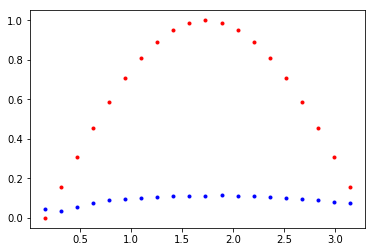


batch_i: 1
step: 1 step*np.pi: 3.14
time_steps: [3.14159265 3.29867229 3.45575192]
(21,)
(21, 1)
x.shape (20, 1)
y.shape (20, 1)
output.shape torch.Size([20, 1])
tensor([[0.2855],
        [0.3197],
        [0.3028]], grad_fn=<SliceBackward>)
hidden.shape torch.Size([1, 1, 32])
loss: tensor(0.8015, grad_fn=<MseLossBackward>)
before step:
 tensor([[-0.1193,  0.1251, -0.0045]], grad_fn=<SliceBackward>)
after step:
 tensor([[-0.1199,  0.1154, -0.0117]], grad_fn=<SliceBackward>)
Loss:  0.8014888167381287


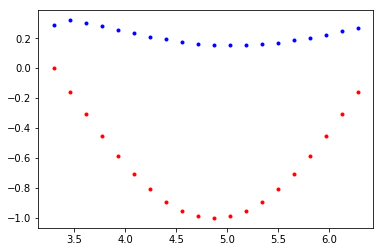


batch_i: 2
step: 2 step*np.pi: 6.28
time_steps: [6.28318531 6.44026494 6.59734457]
(21,)
(21, 1)
x.shape (20, 1)
y.shape (20, 1)
output.shape torch.Size([20, 1])
tensor([[0.2849],
        [0.2839],
        [0.3024]], grad_fn=<SliceBackward>)
hidden.shape torch.Size([1, 1, 32])
loss: tensor(0.1199, grad_fn=<MseLossBackward>)
before step:
 tensor([[-0.1199,  0.1154, -0.0117]], grad_fn=<SliceBackward>)
after step:
 tensor([[-0.1190,  0.1082, -0.0172]], grad_fn=<SliceBackward>)
Loss:  0.11989478766918182


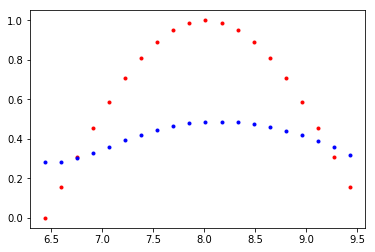

In [6]:
n_steps = 3
print_every = 1

hidden = None

# define training data
for batch_i, step in enumerate(range(n_steps)):
    
    print("\nbatch_i:", batch_i)
    time_steps = np.linspace(step*np.pi, (step+1)*np.pi, seq_length+1)
    print("step:", step, "step*np.pi:", round(step*np.pi,2)) 
    print("time_steps:" , time_steps[:3] )
    
    data = np.sin(time_steps)
    print(data.shape)
    data.resize((seq_length+1, 1))
    print(data.shape)
    
    x = data[:-1]
    y = data[1:]
    
    print("x.shape", x.shape)
    print("y.shape", y.shape)
    
    # convert data to tensors
    x_tensor = torch.Tensor(x).unsqueeze(0) 
    y_tensor = torch.Tensor(y)
    
    # forward method
    # return output, hidden
    output, hidden = rnn(x_tensor, hidden)
    
    print("output.shape", output.shape)
    print(output[:3])
    print("hidden.shape", hidden.shape)
    
    ### Memory ###
    # new hidden variable, detach hidden state from history
    # this way, we don't backpropagate through the entire histoy
    hidden = hidden.data
    
    # calculate loss
    loss = criterion(output, y_tensor)
    print("loss:", loss)
    
    # zero grads
    optimizer.zero_grad()
    
    # backward pass
    loss.backward()
    
    # take one step using gradients
    print("before step:\n",rnn.fc.weight[:,:3])
    optimizer.step()
    print("after step:\n",rnn.fc.weight[:,:3])
    
    if batch_i%print_every == 0:        
        print('Loss: ', loss.item())
        plt.plot(time_steps[1:], x, 'r.') # input
        plt.plot(time_steps[1:], output.data.numpy().flatten(), 'b.') # predictions
        plt.show()
    

#### Training function

In [7]:
# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input 
            
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn

Loss:  0.08485302329063416


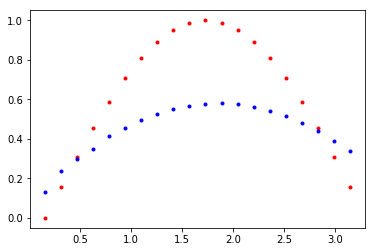

Loss:  0.0038273187819868326


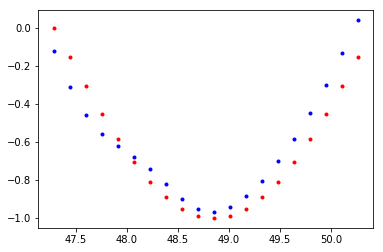

Loss:  0.000656596093904227


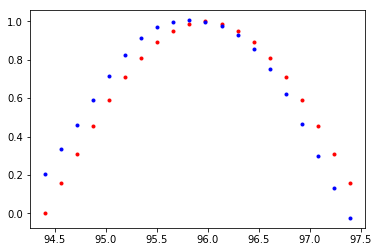

Loss:  0.00028206760180182755


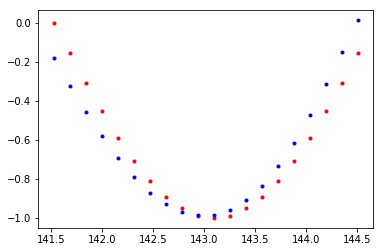

Loss:  0.00015883403830230236


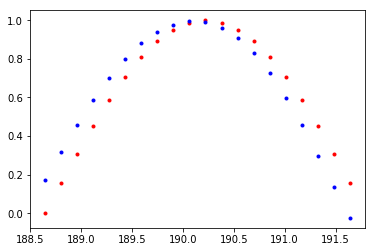

In [8]:
# train the rnn and monitor results
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)

# Main types of recurrent layers in PyTorch

[Recurrent layers](https://pytorch.org/docs/stable/nn.html#recurrent-layers)

- RNN
- LSTM
- GRU

#### nn.RNN

Applies a multi-layer Elman RNN with *tanh* or *ReLU* non-linearity to an input sequence. 

For each element in the input sequence, each layer computes the following function: 

$$
h_t = tanh(W_{ih} \cdot x_t + b_{ih} + W_{hh} \cdot h_{(t-1)} + b_{hh})
$$

- $h_t$ is the hidden state at time t, 
- $x_t$ is the input at time t, 
- $h_{(t-1)}$ is the hidden state of previous layer at time t-1 or the initial hidden state at t=0. 

If `nonlinearity` is `relu`, then *ReLU* is used instead of tanh. 

In [9]:
# Example: nn.RNN
input_size = 10
hidden_size = 20

rnn = nn.RNN(input_size, hidden_size, num_layers=2)
print(rnn)

# input shape: seq_len, batch, input_size
my_input = torch.randn(5, 3, 10)

# shape h0: (num_layers*num_directions, batch, hidden_size)
h0 = torch.randn(2, 3, 20)

output, hn = rnn(my_input, h0)

print("output.shape:",output.shape)
print("output head:\n", output[1,:,:])

RNN(10, 20, num_layers=2)
output.shape: torch.Size([5, 3, 20])
output head:
 tensor([[-0.1749,  0.1909,  0.3233, -0.4792,  0.2153, -0.2828, -0.7586,  0.1570,
         -0.1550,  0.0874, -0.5162, -0.0998, -0.4850,  0.0131, -0.4820, -0.2605,
          0.4668,  0.1515, -0.1409, -0.3984],
        [-0.6768, -0.5892, -0.2499,  0.4492, -0.1796, -0.4533, -0.7268,  0.5228,
         -0.5936, -0.2207, -0.3205, -0.0434, -0.6505,  0.0225,  0.0987, -0.3290,
          0.4113,  0.1889,  0.0050, -0.0591],
        [ 0.4722,  0.3965,  0.4253, -0.5732,  0.1450,  0.5026,  0.0211, -0.3234,
          0.6124,  0.2697,  0.0058, -0.2169, -0.3208, -0.1031, -0.3281,  0.0546,
          0.6647, -0.3990, -0.6432, -0.1397]], grad_fn=<SliceBackward>)


#### nn.LSTM

Applies a multi-layer long short-term memory (LSTM) RNN to an input sequence. For each element in the input sequence, each layer computes the following function: 

$$
\begin{align}
i_t &= \sigma (W_{ii} \cdot x_t + b_{ii} + W_{hi} \cdot h_{(t-1)} + b_{hi}) \\
f_t &= \sigma (W_{if} \cdot x_t + b_{if} + W_{hf} \cdot h_{(t-1)} + b_{hf}) \\
g_t &= tanh(W_{ig} \cdot x_t + b_{ig} + W_{hg}\cdot h_{(t-1)} + b_{hg}) \\
o_t &= \sigma(W_{i0} \cdot x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
c_t &= f_t * c_{(t-1)} + i_t * g_t \\
h_t &= o_t * tanh(c_t) 
\end{align}
$$

where

- $h_t$ is the hidden state at time t
- $c_t$ is the cell state at time t, $x_t$ is the input at time t, 
- $h_{(t-1)}$ is the hidden state of the layer at time t-1 or the initial hidden state at time t=0.
- $i_t$: input gate
- $f_t$: forget gate
- $g_t$: cell state (gate gate)
- $o_t$: output gate
- $\sigma$ is the sigmoid function
- $*$ is the [Hadamard product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)). 
 - It takes two matrices of the same dimensions and produces another matrix of the same dimensions
 - Each element i, j is the product of elements i, j of the original two matrices. 

In a multilayer LSTM, the input $x_t^{(l)}$ of the l-th layer ($l \geq 2$) is the hidden state $h_t^{(l-1)}$ of the previous layer multiplied by dropout $\delta_t ^{(l-1)}$ where each $\delta_t^{(l-1)}$ is a Bernoulli random variable which is 0 with probability `dropout`.

In [10]:
# Example: nn.LSTM
input_size = 10 # number of expected features in the input x
hidden_size = 20 # number of feature in hidden state h
num_layers = 2
batch = 3

my_net = nn.LSTM(input_size, hidden_size, num_layers)
my_net

my_input = torch.randn(5, 3, 10)

# initial hidden shape: num_layers*num_directions, batch, hidden_size
h0 = torch.randn(2, 3, 20)

# initial cell state shape: num_layers*num_directions, batch, hidden_size 
c0 = torch.randn(2, 3, 20)

output, (hn, cn) = my_net(my_input, (h0, c0))

print("input shape:", my_input.shape)
print("LSTM input: {}, LSTM hidden: {}, LSTM layers: {}".format(input_size, hidden_size, num_layers) )

print("output shape:", output.shape)
print("hn shape:", hn.shape)
print("cn shape:", cn.shape)

input shape: torch.Size([5, 3, 10])
LSTM input: 10, LSTM hidden: 20, LSTM layers: 2
output shape: torch.Size([5, 3, 20])
hn shape: torch.Size([2, 3, 20])
cn shape: torch.Size([2, 3, 20])


#### nn.GRU

Applies a multi-layer gated recurrent unit (GRU) RNN to an input sequence. 

For each element in the input sequence, each layer computes the following function: 

$$
\begin{aligned}
r_t &= \sigma (W_{ir} \cdot x_t + b_{ir} + W_{hr} \cdot h_{(t-1)} + b_{hr}) \\
z_t &= \sigma (W_{iz} \cdot b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
n_z &= tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)} + b_{hn})) \\
h_t &= (1-z_t) * n_t + z_t * h_{(t-1)}
\end{aligned}
$$

where 

- $h_t$ is the hidden state at time t, 
- $x_t$ is the input at time t, 
- $h_{(t-1)}$ is the hidden state of the layer at time t-1 or the initial hidden state at time t=0
- $r_t$: reset gate
- $z_t$: update gate
- $n_t$: new gate
- $\sigma$ is the sigmoid function
- $*$ is the Hadamard product

In a multilayer GRU, the input $x_t^{(l)}$ of the l-th layer ($l \geq 2$) is the hidden state $h_t^{(l-1)}$ of the previous layer multiplied by dropout $\delta_t ^{(l-1)}$ where each $\delta_t^{(l-1)}$ is a Bernoulli random variable which is 0 with probability `dropout`.

In [11]:
# Example: nn.GRU
input_size = 10
hidden_size = 20

my_gru = nn.GRU(input_size, hidden_size, num_layers=2)

# input shape: seq_len, batch, input_size
my_input = torch.randn(5, 3, 10)

# initial hidden shape: num_layers*num_directions, batch, hidden_size
h0 = torch.randn(2, 3, 20)

# output shape: seq_len, batch, num_directions*hidden_size
# hn shape: num_layers*num_directions, batch, hidden_size
output, hn = my_gru(my_input, h0)

print("output shape:", output.shape)
print("hn shape:", hn.shape)

output shape: torch.Size([5, 3, 20])
hn shape: torch.Size([2, 3, 20])


In [12]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Character-Level LSTM in PyTorch.ipynb to html',
 '[NbConvertApp] Writing 345384 bytes to Character-Level LSTM in PyTorch.html',
 '[NbConvertApp] Converting notebook Implementation of RNN & LSTM.ipynb to html',
 '[NbConvertApp] Writing 371732 bytes to Implementation of RNN & LSTM.html',
 '[NbConvertApp] Converting notebook Introduction to NLP.ipynb to html',
 '[NbConvertApp] Writing 257096 bytes to Introduction to NLP.html']

In [13]:
print("Done!")

Done!
